In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#dictionary of paper sizes for printing options
'''to add in application: a piece to allow to add custom paper sizes?''' 
paper_size_lib = {'letter':(8.5,11),
                'legal':(8.5,14),
                'tabloid':(11,17)}               

In [3]:
#trig simplification functions for use with degrees instead of rad
def sin(angle_in_deg):
    return np.sin(np.deg2rad(angle_in_deg))
def tan(angle_in_deg):
    return np.tan(np.deg2rad(angle_in_deg))
def cos(angle_in_deg):
    return np.cos(np.deg2rad(angle_in_deg))

In [4]:
#accessory functions for pattern calculation
def triangle(pouf_diameter,point_angle):
    '''A function to return the height (l), width(w) and side lengths (h) of a triangle for the
    given pouf diameter and angle at the triangle peak
    
    ###inputs
    pouf_diameter: desired full width of pillow to be output in inches
    point_angle: desired angle at peak of each triangle segment to make up pouf face
    '''
    #hypotenuse is what will touch the edge of the circle, therefore it is the circle radius
    h = pouf_diameter/2

    #find width of the triangle
    #this calculation is for half the triangles width, so multiply by 2
    w = h*(sin(point_angle/2))
    W = round(2*w,3)

    #define triangle height
    l = w/tan(point_angle/2)

    return l,W,h

def triangle_scale(pouf_diameter,no_triangles):
    '''input the desired diameter of finished pouf and number of triangles desired (minimum 3)
    output will be single triangle pattern for printing to make pouf.
    
    ###inputs:
    pouf diameter:desired full width of pillow to be output in inches
    no_triangles: number of triangles as an integer, must be at least 3'''

    if no_triangles<3:
        return f'Too few triangles requested, please choose at least 3 triangles to make the math happy'

    #First calculate the angle at the peak of the triangle (in the center of the pouf)
    point_angle = 360/no_triangles

    l,W,h = triangle(pouf_diameter,point_angle)

    return point_angle,l,W,h

def round_bottom(radius,angle,mid_x,height):
    '''function to calculate the rounded bottom for the triangle (to create a circular instead of polygonal pillow shape
    
    ###inputs
    radius: radius of circle, h output from triangle functions
    angle: desired angle at peak of each triangle segment
    mid_x: the width of the paper/2, to transpose to center of paper
    height: height of the triangle, l output from triangle functions

    ###output
    this function returns x/y coordinates to plot the rounded bottom onto the triangle
    '''
    line = np.linspace(270-(angle/2),270+(angle/2),600)
    #circle plotted in radians and not deg
    x = radius*cos(line)
    y = radius*sin(line)

    #scale to sit where triangle is sitting in bottom center of page
    x+=mid_x
    y+=height

    return x,y

In [7]:
def pattern_scale(pouf_diameter,no_triangles,paper_size = 'letter',seam=0.25,landscape=True,boundary = "w"):
    '''a function to generate a pattern. Will create a pattern for round floor pouf to sit on, each face will be composed of
    equal sized round bottomed triangles. Pattern will be just one of these triangles, with all seam allowances, saved as a 2 page pdf.
    page 1: pattern with seam allowances and scale-check box (a 1 inch square box to ensure printed product is to scale)
    page 2: instructions for use

    ###inputs
    pouf_diameter: desired full width of pillow to be output in inches
    no_triangles: the number of triangles to divide each face into, must be at least 3
    paper_size: default is letter, see paper_size_lib for all options
    seam: the width of the seams, default is quarter inch
    landscape: pattern will default to landscape, can be changed to portrait aspect by setting to 'False'
    '''
    #test to ensure triangles are integer as math won't work otherwise
    if type(no_triangles)!= 'int':
        int(no_triangles)

    #CALCULATE TRIANGLES
    #calculate the angle, height, width and side length for the triangle
    angle,l,W,h = triangle_scale(pouf_diameter,no_triangles)
    #and again to add the bottom seam length
    l_s,W_s,h_s = triangle(pouf_diameter+(2*seam),angle)
    '''next to add: paper size autoselection/splitting into multiple pages to fit triangle appropriately for printing'''

    #the rounded bottom will extend below zero and be cut off, therefore must raise the triangle up to account for this
    y_diff = (h_s-l)+0.1 #added another small amount to raise the pattern up from touching the bottom of the page

    #PAPER SIZES
    #define paper size x and y as landscape
    paper_y, paper_x = paper_size_lib[paper_size]

    #test printout if the paper is too small
    if l+y_diff >= paper_y or W+(seam*2) >= paper_x:
        #quick test to see if flipping aspect would fix this
        if W+(seam*2) < paper_y and l+y_diff < paper_x:
            landscape=False
        else:
            print("paper size is too small")

    #if landscape is set to false, redefine the paper x and y to respect portrait aspect
    if landscape==False:
        #flip the x and y
        paper_x, paper_y = paper_size_lib[paper_size]

    #to center triangle and round bottom at center of page
    '''to add: paper size scaling for large poufs, or figure out how to export as a 2 page pdf when too large'''
    mid_x = paper_x/2

    #CALCULATIONS FOR SEAM ALLOWANCES/PLOTTING X AND Y COORDS
    #calculation for sin functions below to determine x and y, cleans up below code for readability
    #45 because seams on left and right edges are at a 45 degree angle from the slope
    x = (angle/2) + 45
    
    #seam_a and seam_b are the x/y distances for the point at the corner of the seams at top and bottom of L/R edges
    seam_a = seam*sin(x)/sin(45)
    seam_b = seam*sin(90-x)/sin(45) 

    #define triangle - for seam allowance calculations
    #this is not actually plotted as the triangle is plotted instead with the added seam allowance already added
    #but this is referenced below for the left and right seams so cannot be deleted
    '''maybe will come back and remove this and plot the left/right seam allowances based on the actual values and not just referencing x and y'''
    x = [mid_x-W/2,mid_x,mid_x+W/2]

    #define larger triangle (seam allowance for bottom already included)
    x_s = [mid_x-W_s/2,mid_x,mid_x+W_s/2]
    y_s = [l-l_s,l,l-l_s]
    y_s = [y+y_diff for y in y_s] 

    #define round bottoms (for triangle and at bottom of seam)
    x_round,y_round = round_bottom(h,angle,mid_x,l)
    y_round = [y+y_diff for y in y_round]
    x_round_s,y_round_s = round_bottom(h_s,angle,mid_x,l)
    y_round_s = [y+y_diff for y in y_round_s]

    #define right seam allowance flap
    x_r = [x[1],x[1]+seam_a,x[-1]+seam_b,x[-1]]
    y_r = [l,l-seam_b,0+seam_a,0]
    y_r = [y+y_diff for y in y_r]

    #define left seam allowance flap
    x_l = [x[1],x[1]-seam_a,x[0]-seam_b,x[0]]
    y_l = [l,l-seam_b,0+seam_a,0]
    y_l = [y+y_diff for y in y_l]

    #ASPECT MAINTENANCE
    #define line for visual aspect maintenance (from corner to corner of page size)
    vis_x = (0,paper_x)
    vis_y = (0,paper_y)

    #plot paper boundaries as test (commented out in posted version)
    border_x = (0,paper_x,paper_x,0,0)
    border_y = (0,0,paper_y,paper_y,0)

    #define scalecheck square
    #a one-inch square to ensure appropriate scale of printed pattern, plot in bottom left
    box_x = [0,1,1,0,0]
    box_y = [0,0,1,1,0] 

    #PLOTTING
    #define figure for output, figsize is based on paper size
    plt.figure(num=1,figsize = (paper_x,paper_y),linewidth=2,edgecolor="w")
    #turn of axes to print only the triangle pattern
    plt.axis('off')

    #SCALE MAINTENANCE
    #scale maintenance (line across diagonal of page)
    plt.plot(vis_x,vis_y,boundary)
    plt.plot(border_x,border_y,boundary)
    #add scalecheck box
    plt.plot(box_x,box_y)
    
    #ACTUAL PATTERN PLOTTING
    #plot triangle (with seam allowance added already)
    plt.plot(x_s,y_s,'r.-')
    #plot rounded bottom
    plt.plot(x_round,y_round,"r")

    #add seam allowances
    plt.plot(x_r,y_r,"r.-") #right
    plt.plot(x_l,y_l,"r.-") #left
    plt.plot(x_round_s,y_round_s,"r") #bottom
    plt.show()

    '''next working on how to save this in an appropriate pdf'''
    #save the figure as a pdf
    plt.savefig("outputs\pouf_template.pdf",orientation = 'landscape')

    plt.close()
    return

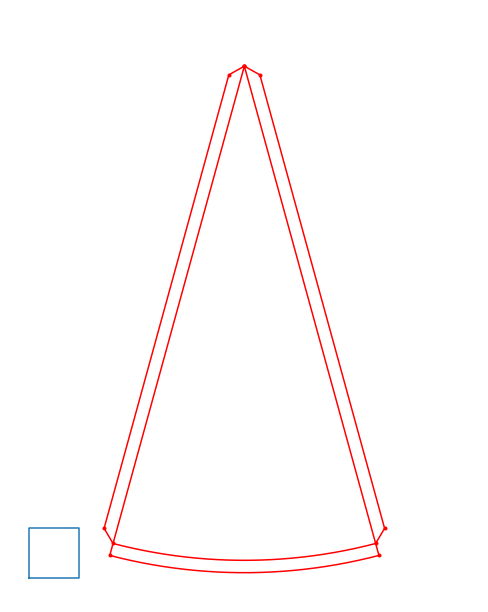

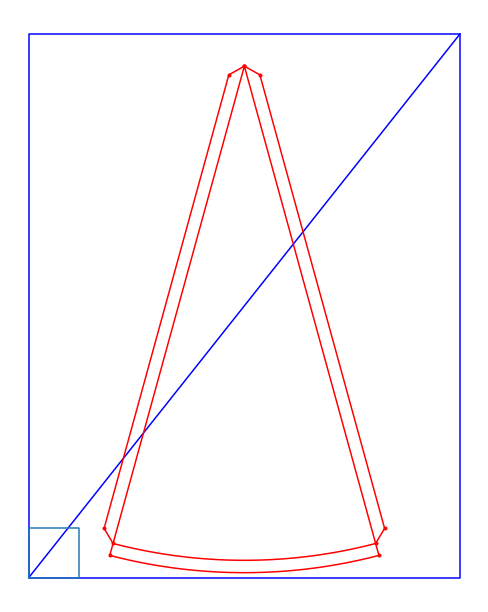

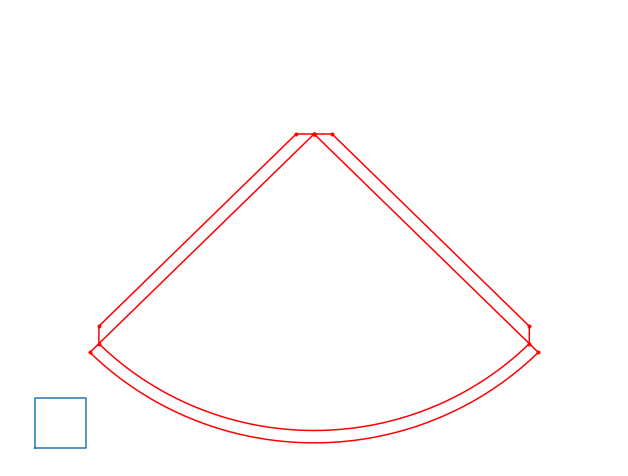

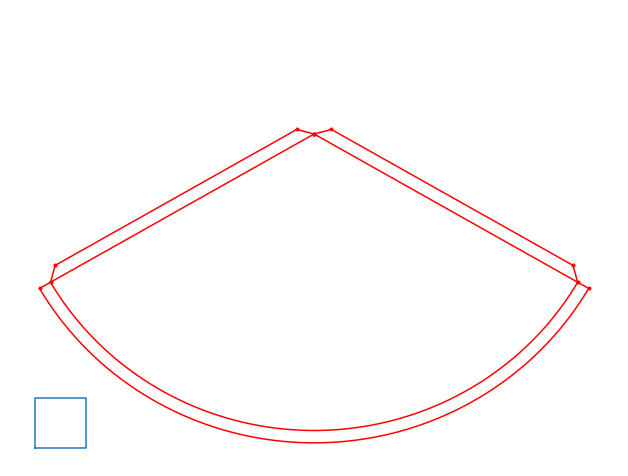

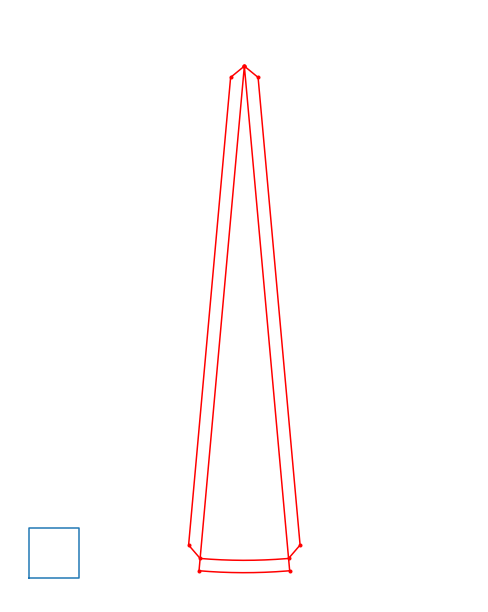

In [8]:
pattern_scale(20,12)
pattern_scale(20,12,boundary="b")
pattern_scale(12,4)
pattern_scale(12,3)
pattern_scale(20,36)